# Box Tensors Demo

In [1]:
import sys
import torch
from typing import List
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
sys.path.append('/fsx/matzeni/duck')

In [2]:
from duck.box_tensors import BoxTensor
from duck.box_tensors.volume import bessel_volume_approx, soft_volume, hard_volume, Volume
from duck.box_tensors.intersection import HardIntersection, GumbelIntersection, Intersection
from duck.box_tensors.functional import stack_box

### Initializing a box tensor

In [3]:
left = [0.0, 0.0]
right = [1.0, 1.0]
data = torch.tensor([left, right])
box1 = BoxTensor(data)
box1

BoxTensor(
tensor([[0., 0.],
        [1., 1.]])
)

In [4]:
print("Center of the box:")
print(box1.center)

Center of the box:
tensor([0.5000, 0.5000])


### Box Volume

In [5]:
# Log Soft volume
print(f"Log soft volume: {soft_volume(box1):.2f}")

# Soft volume
print(f"Soft volume: {soft_volume(box1, log_scale=False):.2e}")

print()

# Log Bessel volume
print(f"Log bessel volume: {bessel_volume_approx(box1):.2f}")

# Bessel volume
print(f"Bessel volume: {bessel_volume_approx(box1, log_scale=False):.2e}")

print()

# Log hard volume
print(f"Log hard volume: {hard_volume(box1):.2f}")

# Hard volume
print(f"Hard volume: {hard_volume(box1, log_scale=False):.2e}")

Log soft volume: 0.55
Soft volume: 1.72e+00

Log bessel volume: -0.96
Bessel volume: 3.83e-01

Log hard volume: 0.00
Hard volume: 1.00e+00


### Box Intersection

In [6]:
# Creating two boxes
left1 = [0.0, 0.0]
right1 = [1.0, 1.0]
data1 = torch.tensor([left1, right1])
box1 = BoxTensor(data1)

left2 = [-0.5, -0.5]
right2 = [0.5, 0.5]
data2 = torch.tensor([left2, right2], requires_grad=True)
box2 = BoxTensor(data2)

hard_intersection = HardIntersection()
gumbel_intersection = GumbelIntersection(intersection_temperature=0.1)

print("Hard intersection:")
# Intersection of box1 and box2
print(hard_intersection(box1, box2))

print()

print("Gumbel intersection:")
# Gumbel intersection of box1 and box2
print(gumbel_intersection(box1, box2))

Hard intersection:
BoxTensor(
	left=tensor([0., 0.], grad_fn=<MaxBackward0>),
	right=tensor([0.5000, 0.5000], grad_fn=<MinBackward0>)
)

Gumbel intersection:
BoxTensor(
	left=tensor([0.0007, 0.0007], grad_fn=<MulBackward0>),
	right=tensor([0.4993, 0.4993], grad_fn=<MulBackward0>)
)


## Box Training

In [7]:
left1 = np.array([-2.0 for n in range(1, 16)])
right1 = np.array([0.0 for k in left1])
data1 = np.array([left1, right1])
data1 = torch.tensor(data1, requires_grad=True)
box1 = BoxTensor(data1)

left2 = np.array([1 / n for n in range(1, 16)])
right2 = np.array([1 + k for k in reversed(left2)])
data2 = np.array([left2, right2])
data2 = torch.tensor(data2, requires_grad=True)
box2 = BoxTensor(data2)

# Training loop
learning_rate = 0.1
def train(box1, box2, optimizer, epochs=1):
    best_loss = int()
    best_box_1 = None
    best_box_2 = None
    box_vol = Volume(volume_temperature=0.1, intersection_temperature=0.0001)
    box_int = Intersection(intersection_temperature=0.0001)
    for e in range(epochs):
        loss = box_vol(box2) - box_vol(box_int(box1, box2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if best_loss < loss.item():
            best_loss = loss.item()
            best_box_2 = box2
            best_box_1 = box1
        print('Iteration %d, loss = %.4f' % (e, loss.item()))
    return best_box_1, best_box_2

optimizer = torch.optim.SGD([data1, data2], lr=learning_rate)
contained_box1, contained_box2 = train(box1, box2, optimizer, epochs=20)
# Print the coordinates of the boxes after training
print(contained_box1)
print(contained_box2)

Iteration 0, loss = 67.5864
Iteration 1, loss = 1.9609
Iteration 2, loss = 1.2382
Iteration 3, loss = 0.8086
Iteration 4, loss = 0.5695
Iteration 5, loss = 0.4213
Iteration 6, loss = 0.3193
Iteration 7, loss = 0.2446
Iteration 8, loss = 0.2030
Iteration 9, loss = 0.1628
Iteration 10, loss = 0.1237
Iteration 11, loss = 0.0855
Iteration 12, loss = 0.0478
Iteration 13, loss = 0.0105
Iteration 14, loss = -0.0000
Iteration 15, loss = -0.0000
Iteration 16, loss = -0.0000
Iteration 17, loss = -0.0000
Iteration 18, loss = -0.0000
Iteration 19, loss = -0.0000
BoxTensor(
tensor([[-2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
         -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000],
        [ 1.0000,  0.9967,  0.9827,  1.0260,  1.0031,  0.9823,  0.9643,  1.0109,
          0.9980,  0.9869,  1.0375,  1.0291,  1.0792,  1.1801,  1.4934]],
       dtype=torch.float64, requires_grad=True)
)
BoxTensor(
tensor([[ 0.6114, -0.3223, -0.5149, -0.5917, -0.6285, -0.6475,

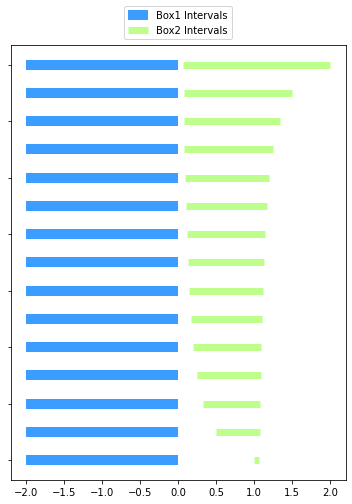

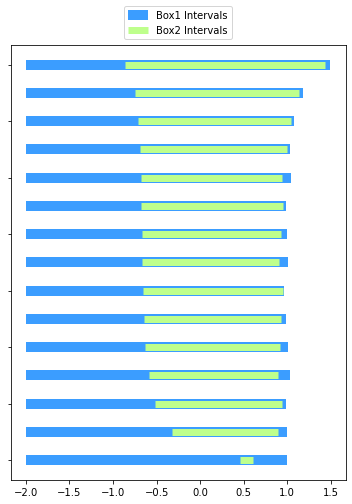

In [8]:
# Visualization functions
def plot_dimension_interval(
    ax, cmap, dim, box1, box2,
    color1='#3b9dff', color2='#beff8c', label=False):
    if not label:
        ax.hlines(dim, box1[0], box1[1], color1, lw=10)
        ax.hlines(dim, box2[0], box2[1], color2, lw=7)
    else:
        ax.hlines(dim, box1[0], box1[1], color1, lw=10, label='Box1 Intervals', cmap=cmap)
        ax.hlines(dim, box2[0], box2[1], color2, lw=7, label='Box2 Intervals', cmap=cmap)

def plot_x_and_y_box(axs, cmap, left1, right1, left2, right2):
    for dim in range(left2.shape[0]):
        p = dim % axs.shape[0]
        plot_dimension_interval(
            axs[p][0], cmap, dim,
            [left1[dim], right1[dim]], [left2[dim], right2[dim]],
            label=(dim==0)
        )
    for i in range(axs.shape[0]):
        axs[i][0].yaxis.set_ticklabels([])
    axs[0][0].legend(bbox_to_anchor=(0.5, 1.1), loc="upper center")

# Plot the coordinates of the boxes before training
fig, axs = plt.subplots(1, 1, figsize=(6,8))
axs = np.array([axs], dtype=object).reshape(1, 1)
cmap = matplotlib.cm.get_cmap('Pastel1')
mappable = matplotlib.cm.ScalarMappable(cmap=cmap)
plot_x_and_y_box(axs, cmap, left1, right1, left2, right2)
plt.show()

# Plot the coordinates of the boxes after training
fig, axs = plt.subplots(1, 1, figsize=(6,8))
axs = np.array([axs], dtype=object).reshape(1, 1)
plot_x_and_y_box(axs, cmap, contained_box1.left.detach().numpy(), contained_box1.right.detach().numpy(),
                 contained_box2.left.detach().numpy(), contained_box2.right.detach().numpy())
plt.show()
